ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. Creating an automated system to estimate the annual medical expenditure for new customers, using information such as their age, sex, BMI, children, smoking habits and region of residence.

Estimates will be used to determine the annual insurance premium (amount paid every month) offered to the customer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor
import tpot
from tpot import TPOTRegressor

In [2]:
df = pd.read_csv(r'expenses.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.shape

(1338, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
data = df.copy()

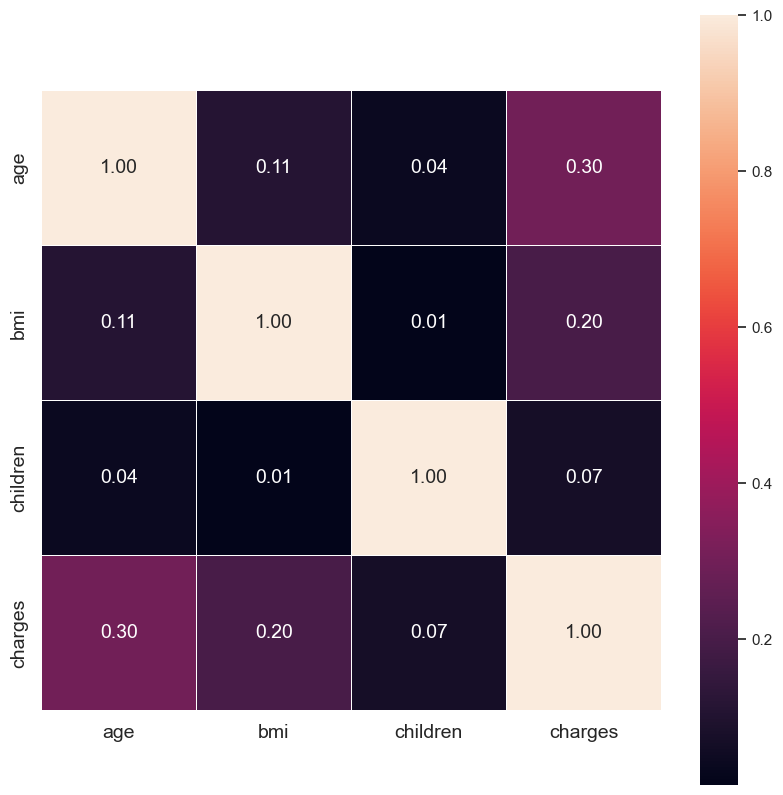

In [9]:
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(data.corr(), annot = True, square = True, fmt = '.2f', annot_kws={"size": 14}, linewidths = 0.5)
ax.xaxis.set_tick_params(labelsize = 14)
ax.yaxis.set_tick_params(labelsize = 14)

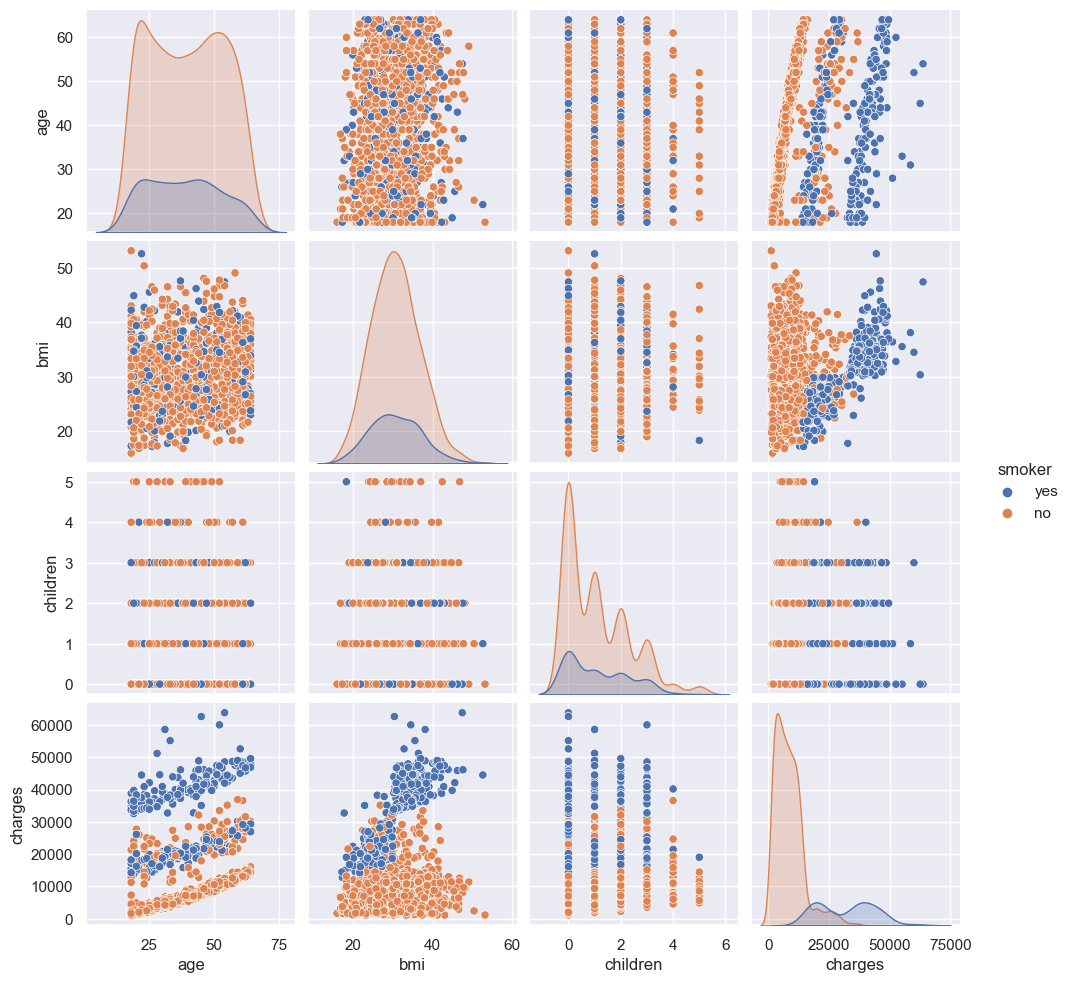

In [10]:
sns.pairplot(data, hue = 'smoker')

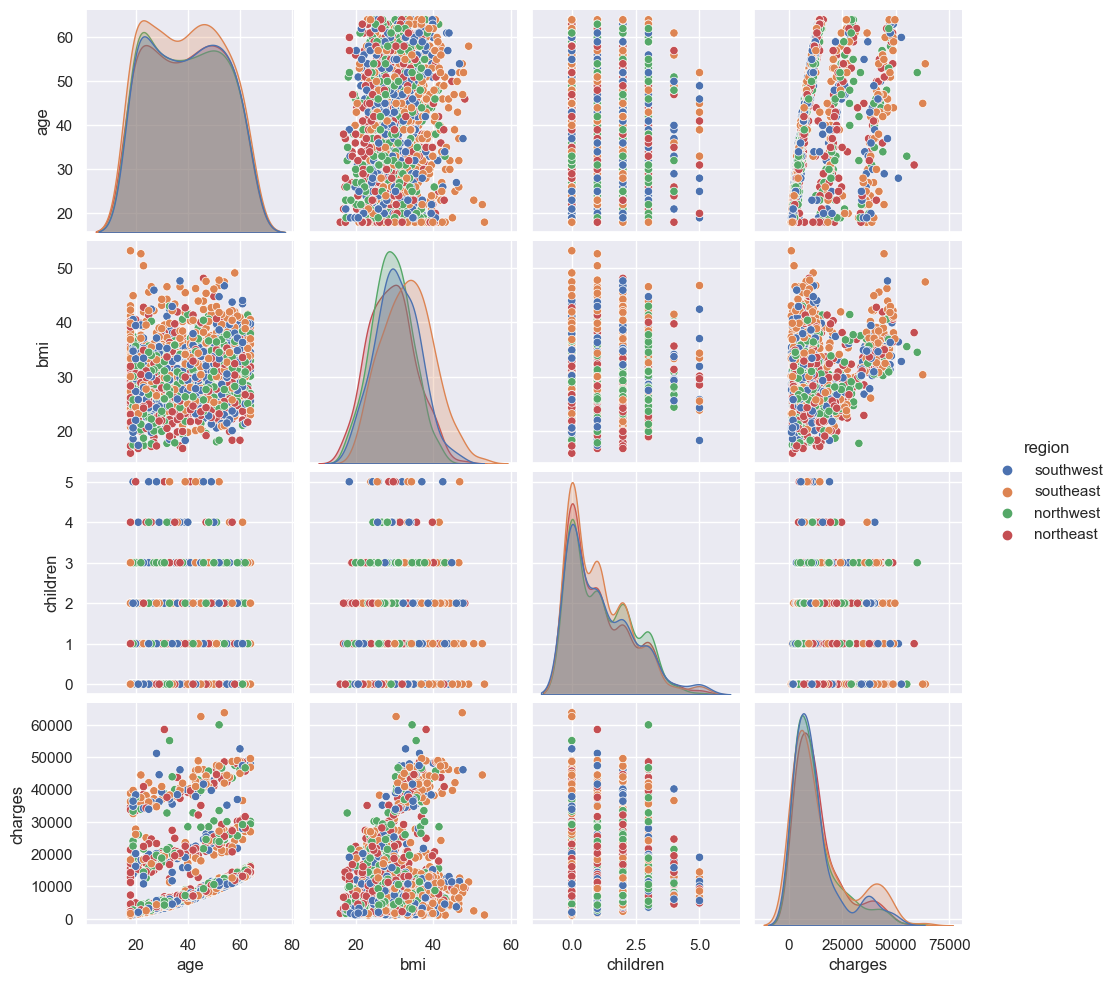

In [11]:
sns.pairplot(data, hue = 'region')

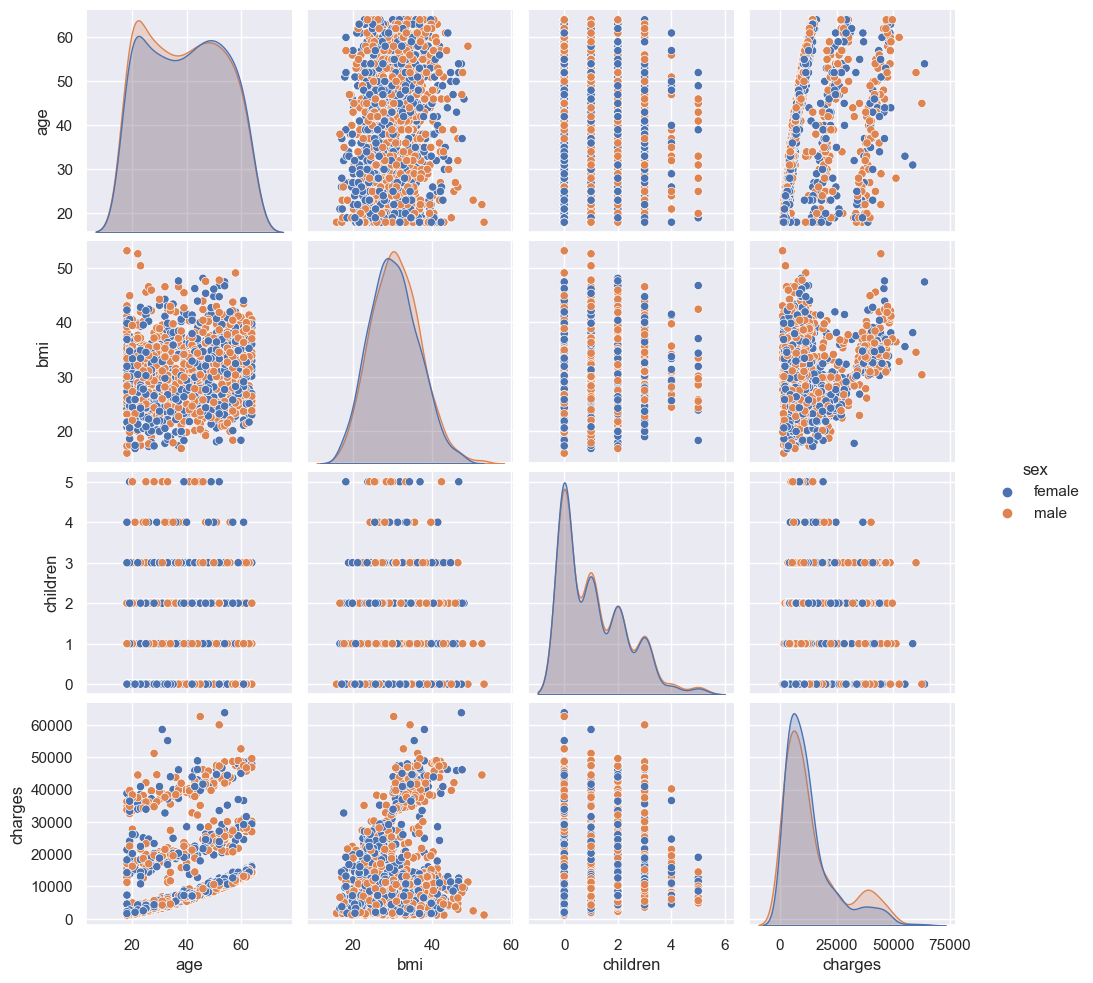

In [12]:
sns.pairplot(data, hue = 'sex')

In [13]:
data['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

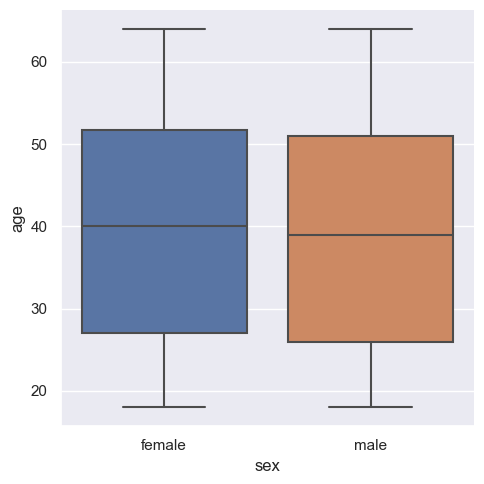

In [14]:
sns.catplot(x = 'sex', y = 'age', data = data, kind = 'box')

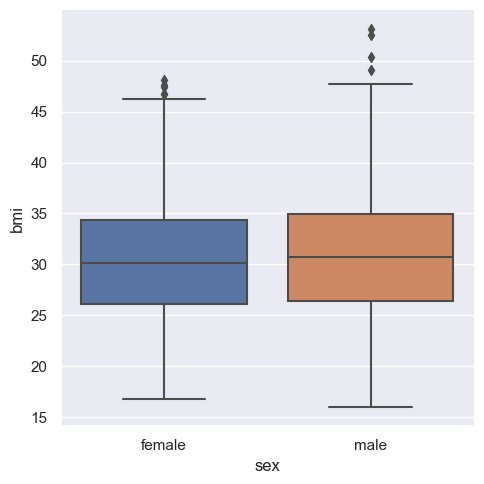

In [15]:
sns.catplot(x = 'sex', y = 'bmi', data = data, kind = 'box')

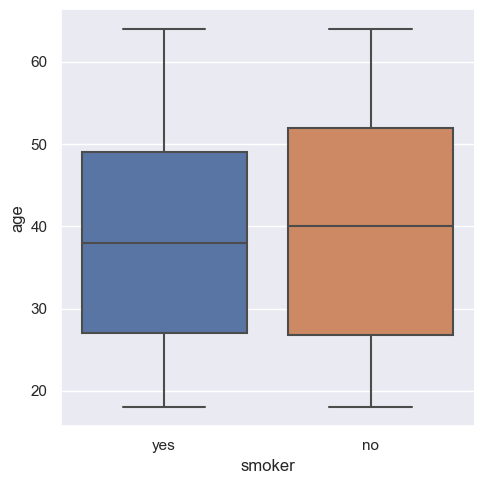

In [16]:
sns.catplot(x = 'smoker', y = 'age', data = data, kind = 'box')

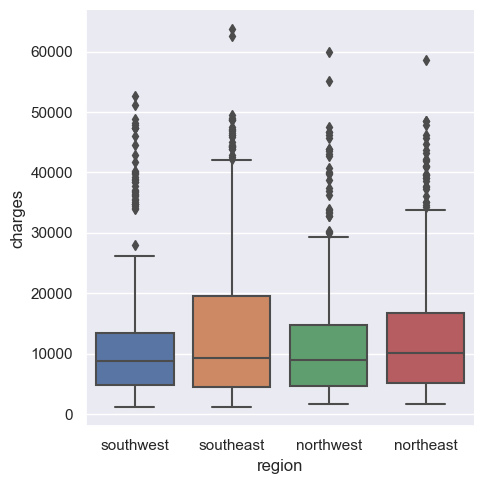

In [17]:
sns.catplot(x = 'region', y = 'charges', data = data, kind = 'box')

In [18]:
data.groupby(by = 'sex')['smoker'].value_counts()

sex     smoker
female  no        547
        yes       115
male    no        517
        yes       159
Name: smoker, dtype: int64

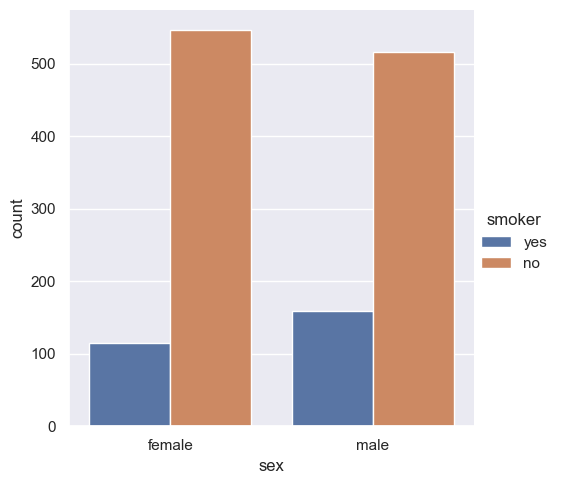

In [19]:
sns.catplot(x = 'sex', data = data, hue = 'smoker', kind = 'count')

Defining Adult Overweight & Obesity:
If your BMI is less than 18.5, it falls within the underweight range.
If your BMI is 18.5 to <25, it falls within the healthy weight range.
If your BMI is 25.0 to <30, it falls within the overweight range.
If your BMI is 30.0 or higher, it falls within the obesity range.
https://www.cdc.gov/obesity/basics/adult-defining.html

In [20]:
weight_status = []
for w in data['bmi'].values:
    weight_status.append( 'underweight' if w < 18.5 else 'normal weight' if w < 25 else 'overweight' if w < 30 else 'obesity' )
data['weight_status'] = weight_status

In [21]:
data.head()

,age,sex,bmi,children,smoker,region,charges,weight_status
0,19,female,27.900,0,yes,southwest,16884.92400,overweight
1,18,male,33.770,1,no,southeast,1725.55230,obesity
2,28,male,33.000,3,no,southeast,4449.46200,obesity
3,33,male,22.705,0,no,northwest,21984.47061,normal weight
4,32,male,28.880,0,no,northwest,3866.85520,overweight


In [22]:
data.groupby('sex')['weight_status'].value_counts()

sex     weight_status
female  obesity          334
        overweight       199
        normal weight    117
        underweight       12
male    obesity          373
        overweight       187
        normal weight    108
        underweight        8
Name: weight_status, dtype: int64

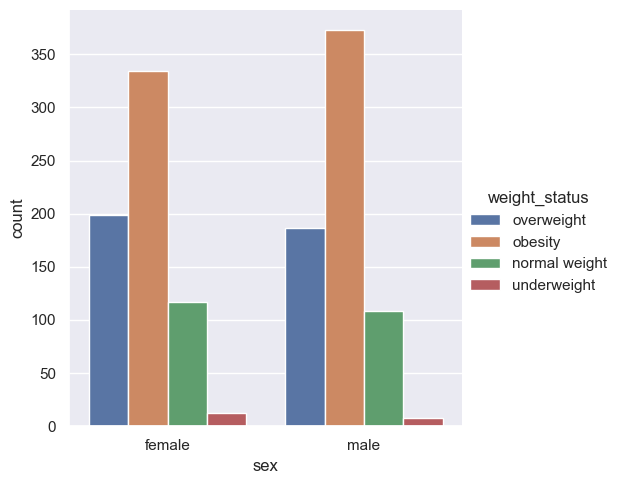

In [23]:
sns.catplot(x = 'sex', data = data, hue = 'weight_status', kind = 'count')

In [24]:
data.groupby('weight_status')['smoker'].value_counts()

weight_status  smoker
normal weight  no        175
               yes        50
obesity        no        562
               yes       145
overweight     no        312
               yes        74
underweight    no         15
               yes         5
Name: smoker, dtype: int64

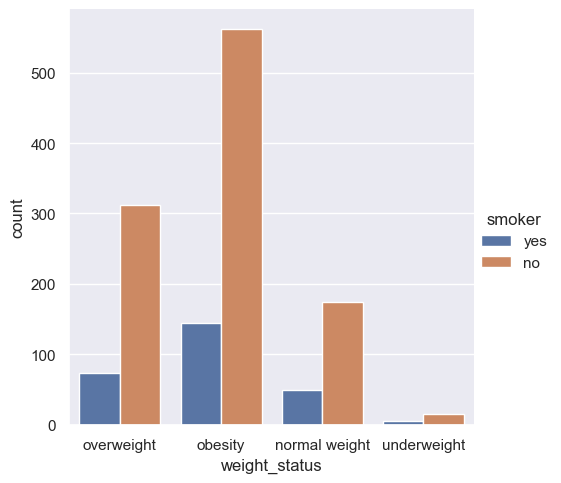

In [25]:
sns.catplot(x = 'weight_status', data = data, hue = 'smoker', kind = 'count')

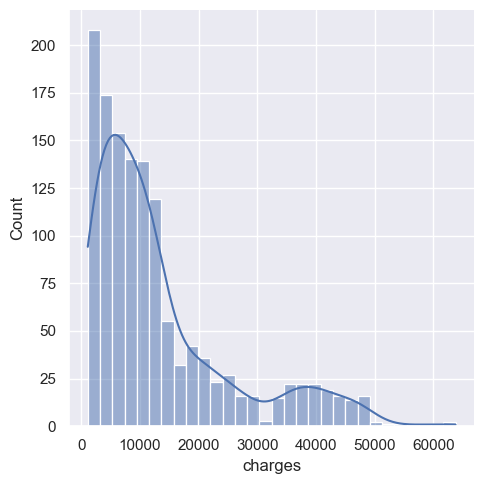

In [26]:
sns.displot(data.charges, kde = True)

<AxesSubplot:xlabel='bmi', ylabel='Density'>

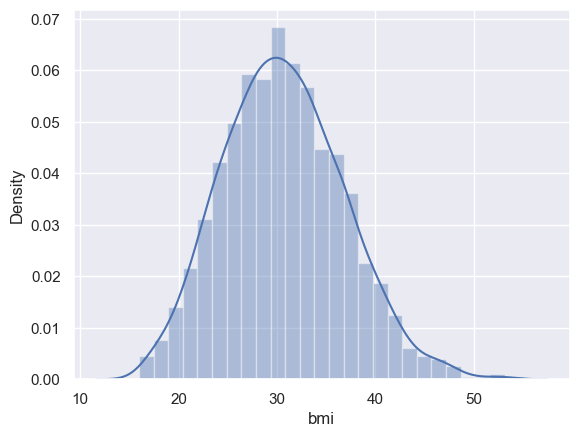

In [27]:
sns.distplot(data.bmi, kde = True)

<AxesSubplot:xlabel='age', ylabel='Density'>

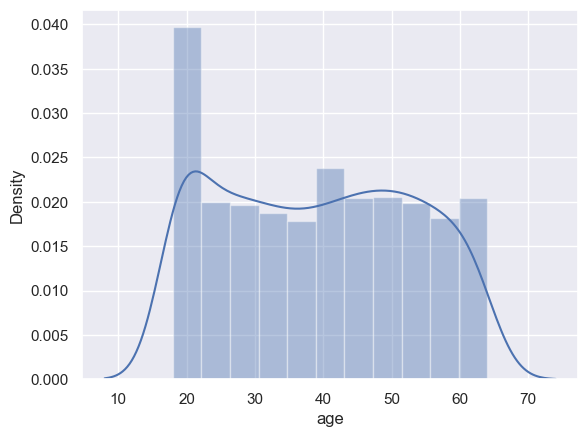

In [28]:
sns.distplot(data.age, kde = True)

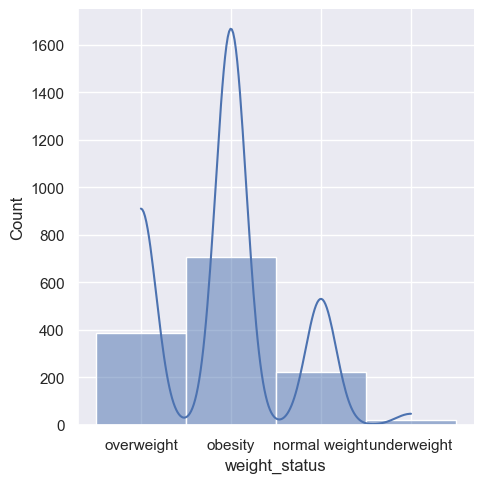

In [29]:
sns.displot(data.weight_status, kde = True)

In [30]:
y = data['charges']
X = pd.get_dummies(data.drop('charges', axis=1), drop_first = True)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

In [32]:
lasso = Lasso(random_state = 22)
lasso_params = {'alpha' : np.arange(0.5, 3, 0.5)}
cv = GridSearchCV(lasso, param_grid = lasso_params, cv = 5)
cv.fit(X, y)

GridSearchCV(cv=5, estimator=Lasso(random_state=22),
             param_grid={'alpha': array([0.5, 1. , 1.5, 2. , 2.5])})

In [33]:
print(cv.cv_results_)

{'mean_fit_time': array([0.05497336, 0.03866754, 0.07574897, 0.03800015, 0.05782843]), 'std_fit_time': array([0.04241323, 0.04185141, 0.0359242 , 0.041704  , 0.04250378]), 'mean_score_time': array([0.00249238, 0.00236816, 0.00219073, 0.00219002, 0.0024087 ]), 'std_score_time': array([0.00022237, 0.00025315, 0.00013512, 0.00023158, 0.00023844]), 'param_alpha': masked_array(data=[0.5, 1.0, 1.5, 2.0, 2.5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 0.5}, {'alpha': 1.0}, {'alpha': 1.5}, {'alpha': 2.0}, {'alpha': 2.5}], 'split0_test_score': array([0.7647386 , 0.76478057, 0.76482163, 0.76486174, 0.76490102]), 'split1_test_score': array([0.70602432, 0.70610961, 0.7061942 , 0.70627835, 0.70636177]), 'split2_test_score': array([0.78070408, 0.78071635, 0.78072817, 0.78074002, 0.78075072]), 'split3_test_score': array([0.73762725, 0.73764144, 0.73765508, 0.737668  , 0.73768062]), 'split4_test_score': array([0.763386

In [34]:
print(cv.best_params_)

{'alpha': 2.5}


In [35]:
print(cv.best_score_)

0.7506282705525029


In [36]:
print(cv.best_estimator_)

Lasso(alpha=2.5, random_state=22)


In [37]:
lasso = Lasso(alpha=2.5, random_state=22)

In [38]:
lasso.fit(X_train, y_train)

Lasso(alpha=2.5, random_state=22)

In [39]:
y_pred_lasso = lasso.predict(X_test)

In [40]:
print(np.sqrt(mean_squared_error(y_test, y_pred_lasso)), lasso.score(X_test, y_test))

5890.235618424436 0.764190123222227


In [41]:
rf_reg = RandomForestRegressor(random_state = 22)
params = {'n_estimators' : [25, 50, 75, 100, 125], 'max_depth' : [2, 4, 6, 8]}
rf_cv = GridSearchCV(rf_reg, param_grid = params, cv = 5)
rf_cv.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=22),
             param_grid={'max_depth': [2, 4, 6, 8],
                         'n_estimators': [25, 50, 75, 100, 125]})

In [42]:
print(rf_cv.cv_results_)

{'mean_fit_time': array([0.03936734, 0.06732578, 0.10132794, 0.12489223, 0.15663419,
       0.04013977, 0.07943559, 0.11524067, 0.15463872, 0.19623141,
       0.04895582, 0.09153514, 0.14118276, 0.18346915, 0.22987337,
       0.05472488, 0.11340561, 0.16469889, 0.21397934, 0.2652926 ]), 'std_fit_time': array([0.00305805, 0.00392211, 0.0059067 , 0.00056533, 0.00362736,
       0.00085034, 0.00224098, 0.00093813, 0.00190817, 0.00326923,
       0.00119073, 0.00045186, 0.00595585, 0.0025271 , 0.0047739 ,
       0.00014127, 0.0081314 , 0.0049635 , 0.00167517, 0.00092047]), 'mean_score_time': array([0.00405359, 0.00547767, 0.0069643 , 0.00862508, 0.01011534,
       0.00361996, 0.00569606, 0.00744171, 0.0091917 , 0.01158614,
       0.00393457, 0.00586662, 0.00946436, 0.00990806, 0.01277137,
       0.00394616, 0.00691152, 0.00875149, 0.01087279, 0.01305699]), 'std_score_time': array([7.61530663e-04, 5.07638115e-04, 3.81938694e-04, 1.38910562e-04,
       2.08277504e-04, 8.83294985e-06, 4.4297053

In [43]:
print(rf_cv.best_params_)

{'max_depth': 4, 'n_estimators': 100}


In [44]:
print(rf_cv.best_score_)

0.8566835724795847


In [45]:
print(rf_cv.best_estimator_)

RandomForestRegressor(max_depth=4, random_state=22)


In [46]:
rf_reg.n_estimators = 75
rf_reg.max_depth = 4
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=75, random_state=22)

In [47]:
y_pred_rf = rf_reg.predict(X_test)

In [48]:
print(np.sqrt(mean_squared_error(y_test, y_pred_rf)), rf_reg.score(X_test, y_test))

4983.368523022774 0.8312115731100749


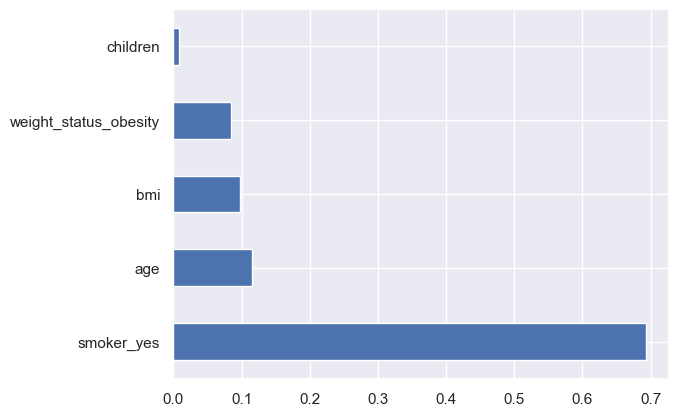

In [49]:
ranked_features = pd.Series(rf_reg.feature_importances_, index = X.columns)
ranked_features.nlargest().plot(kind='barh')
plt.show()

In [50]:
gb_reg = GradientBoostingRegressor(random_state = 22)
gb_params = {'n_estimators' : [25, 50, 75, 100, 125], 'max_depth' : [2, 4, 6, 8]}
gb_cv = GridSearchCV(gb_reg, param_grid = gb_params, cv = 5)
gb_cv.fit(X, y)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=22),
             param_grid={'max_depth': [2, 4, 6, 8],
                         'n_estimators': [25, 50, 75, 100, 125]})

In [51]:
print(gb_cv.cv_results_)

{'mean_fit_time': array([0.02279015, 0.0420754 , 0.06295223, 0.08093262, 0.10127764,
       0.03311033, 0.06304593, 0.09248395, 0.12407284, 0.15300941,
       0.0440464 , 0.08535643, 0.12829719, 0.16895566, 0.21350546,
       0.05678058, 0.10782456, 0.16238799, 0.21272068, 0.27279043]), 'std_fit_time': array([0.00133222, 0.00136973, 0.00109877, 0.00126825, 0.00049343,
       0.00099695, 0.00071617, 0.00087711, 0.00156471, 0.00126942,
       0.00138794, 0.00270624, 0.0036283 , 0.00318192, 0.00957166,
       0.00288103, 0.00047564, 0.00172518, 0.00146752, 0.01114045]), 'mean_score_time': array([0.00161748, 0.0018858 , 0.00198283, 0.00211945, 0.00215707,
       0.00198393, 0.00207572, 0.00216179, 0.00236363, 0.00249677,
       0.00201988, 0.00229559, 0.00263195, 0.00297961, 0.00304098,
       0.00223918, 0.00263557, 0.00316567, 0.00340157, 0.00371799]), 'std_score_time': array([1.10901437e-04, 2.14362016e-04, 3.25315490e-05, 6.63678874e-05,
       2.04187662e-05, 9.17248548e-05, 2.0120140

In [52]:
print(gb_cv.best_params_)

{'max_depth': 2, 'n_estimators': 100}


In [53]:
print(gb_cv.best_score_)

0.8596029547553755


In [54]:
print(gb_cv.best_estimator_)

GradientBoostingRegressor(max_depth=2, random_state=22)


In [55]:
gb_reg.n_estimators = 100
gb_reg.max_depth = 2
gb_reg.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, random_state=22)

In [56]:
y_pred_gb = gb_reg.predict(X_test)

In [57]:
print(np.sqrt(mean_squared_error(y_test, y_pred_gb)), gb_reg.score(X_test, y_test))

4779.738753743333 0.8447237706813728


In [58]:
estimators = [('random forest', RandomForestRegressor(n_estimators = 75, max_depth = 4, random_state = 22)), ('gbr', GradientBoostingRegressor(n_estimators = 100, max_depth = 2, random_state = 22))]

In [59]:
reg = StackingRegressor(estimators=estimators, final_estimator= BaggingRegressor(n_estimators = 100, random_state = 22))

In [60]:
reg.fit(X_train, y_train)

StackingRegressor(estimators=[('random forest',
                               RandomForestRegressor(max_depth=4,
                                                     n_estimators=75,
                                                     random_state=22)),
                              ('gbr',
                               GradientBoostingRegressor(max_depth=2,
                                                         random_state=22))],
                  final_estimator=BaggingRegressor(n_estimators=100,
                                                   random_state=22))

In [61]:
reg_pred = reg.predict(X_test)

In [62]:
print(np.sqrt(mean_squared_error(y_test, reg_pred)), reg.score(X_test, y_test))

4811.908369746536 0.8426265905922866


In [63]:
tpot = TPOTRegressor(generations = 5, population_size = 50, verbosity=2, offspring_size = None, scoring = 'neg_mean_squared_error', cv=5)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_boston_pipeline.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -20127857.62098825

Generation 2 - Current best internal CV score: -19984084.14599324

Generation 3 - Current best internal CV score: -19867690.995944455

Generation 4 - Current best internal CV score: -19867690.995944455

Generation 5 - Current best internal CV score: -19676387.861983538

Best pipeline: ExtraTreesRegressor(ElasticNetCV(input_matrix, l1_ratio=0.6000000000000001, tol=0.001), bootstrap=True, max_features=1.0, min_samples_leaf=7, min_samples_split=16, n_estimators=100)
-23662900.86144288
